In [58]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from dynamics import SatelliteDynamics
from scipy.optimize import approx_fprime
from scipy.linalg import block_diag, solve
from utils import get_form_initial_conditions

In [59]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 100 # Window size [min]

In [60]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [61]:
def h_function_chief(x_vec):
    """
    Computes the measurement vector based on the current state vector.
    The measurement vector includes position components.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).
    """
    return x_vec[0:3]

def H_jacobian_chief():
    """
    Computes the Jacobian of the measurement function.
    """
    H = np.zeros((3, 24))
    H[0:3, 0:3] = np.eye(3)
    return H

def h_function_deputy(x_vec):
    """
    Computes the measurement vector based on the current state vector.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    y (np.array): The measurement vector of the satellite (range [km]).
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    return np.array(
        [
            [range_deputy1_chief],
            [range_deputy1_deputy2],
            [range_deputy1_deputy3],
            [range_deputy2_chief],
            [range_deputy2_deputy3],
            [range_deputy3_chief],
        ]
    )

def H_jacobian_deputy(x_vec):
    """
    Computes the Jacobian of the measurement function.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    H (np.array): The Jacobian of the measurement function.
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    H = np.zeros((6, 24))
    H[0, 0:3] = -(r_deputy1 - r_chief).reshape(-1) / range_deputy1_chief
    H[0, 6:9] = (r_deputy1 - r_chief).reshape(-1) / range_deputy1_chief
    H[1, 6:9] = (r_deputy1 - r_deputy2).reshape(-1) / range_deputy1_deputy2
    H[1, 12:15] = -(r_deputy1 - r_deputy2).reshape(-1) / range_deputy1_deputy2
    H[2, 6:9] = (r_deputy1 - r_deputy3).reshape(-1) / range_deputy1_deputy3
    H[2, 18:21] = -(r_deputy1 - r_deputy3).reshape(-1) / range_deputy1_deputy3
    H[3, 0:3] = -(r_deputy2 - r_chief).reshape(-1) / range_deputy2_chief
    H[3, 12:15] = (r_deputy2 - r_chief).reshape(-1) / range_deputy2_chief
    H[4, 12:15] = (r_deputy2 - r_deputy3).reshape(-1) / range_deputy2_deputy3
    H[4, 18:21] = -(r_deputy2 - r_deputy3).reshape(-1) / range_deputy2_deputy3
    H[5, 0:3] = -(r_deputy3 - r_chief).reshape(-1) / range_deputy3_chief
    H[5, 18:21] = (r_deputy3 - r_chief).reshape(-1) / range_deputy3_chief
    return H

def h(x_vec):
    return np.concatenate([h_function_chief(x_vec), h_function_deputy(x_vec)])

def H(x):
    return np.concatenate((H_jacobian_chief(), H_jacobian_deputy(x)))

In [62]:
# Simulation setup
np.random.seed(42)
X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [ ]:
def f(x_0, y):
    f_x_0 = 0

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    
    # Iterate over all sliding window time steps
    for k in range(W):    
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Update the cost function with the residuals for self-measurements
        residual = y_1_k - P @ x_1_k
        f_x_0 += 1 / 2 * residual.T @ np.linalg.inv(R_chief) @ residual

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and update the cost function with the residuals for pairwise measurements
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            f_x_0 += (y_ij_k - d_ij_k) ** 2 / (2 * r_deputy_pos**2)
        
        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            x_1_k = SatelliteDynamics().x_new(dt, x_1_k)
            x_2_k = SatelliteDynamics().x_new(dt, x_2_k)
            x_3_k = SatelliteDynamics().x_new(dt, x_3_k)
            x_4_k = SatelliteDynamics().x_new(dt, x_4_k)

    return f_x_0

def grad_f(x_0, y):
    grad_f_x_0 = np.zeros_like(x_0)

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    F_1_k = np.eye(n_x)
    F_2_k = np.eye(n_x)
    F_3_k = np.eye(n_x)
    F_4_k = np.eye(n_x)
    
    # Iterate over all sliding window time steps
    for k in range(W):
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Compute gradients for the absolute residual terms
        grad_f_x_0[:n_x, :] -= F_1_k.T @ P.T @ np.linalg.inv(R_chief) @ (y_1_k - P @ x_1_k)

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k, F_2_k, F_1_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k, F_2_k, F_3_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k, F_2_k, F_4_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k, F_3_k, F_1_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k, F_3_k, F_4_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k, F_4_k, F_1_k),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the gradient of f(x) with respect to x_i(k) and x_j(k)
            grad_f_x_0[(i - 1) * n_x:i * n_x, :] -= (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_i.T @ P.T @ d_ij_k_vec) / d_ij_k
            grad_f_x_0[(j - 1) * n_x:j * n_x, :] += (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_j.T @ P.T @ d_ij_k_vec) / d_ij_k
        
        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            F_1_old = F_1_k
            F_2_old = F_2_k
            F_3_old = F_3_k
            F_4_old = F_4_k
            x_1_k, F_1_k = SatelliteDynamics().x_new_and_F(dt, x_1_k)
            x_2_k, F_2_k = SatelliteDynamics().x_new_and_F(dt, x_2_k)
            x_3_k, F_3_k = SatelliteDynamics().x_new_and_F(dt, x_3_k)
            x_4_k, F_4_k = SatelliteDynamics().x_new_and_F(dt, x_4_k)
            F_1_k = F_1_k @ F_1_old
            F_2_k = F_2_k @ F_2_old
            F_3_k = F_3_k @ F_3_old
            F_4_k = F_4_k @ F_4_old
            print(F_1_k)

    return grad_f_x_0
    
def numerical_gradient(f, x_0, y, epsilon=1e-6):
    """
    Compute the numerical gradient of f at x_0 using finite differences.
    
    Args:
        f (function): The cost function.
        x_0 (numpy.ndarray): The current state vector.
        STM (numpy.ndarray): State transition matrix.
        y (numpy.ndarray): Observed data.
        epsilon (float): Small perturbation for finite differences.

    Returns:
        numpy.ndarray: Numerical gradient of f at x_0.
    """
    grad = np.zeros_like(x_0)
    for i in range(x_0.size):
        # Create perturbed versions of x_0
        x_0_plus = x_0.copy()
        x_0_minus = x_0.copy()
        
        # Add and subtract epsilon to the i-th component
        x_0_plus[i] += epsilon
        x_0_minus[i] -= epsilon
        
        # Compute the function value for perturbed inputs
        f_plus = f(x_0_plus, y)
        f_minus = f(x_0_minus, y)
        
        # Central difference approximation
        grad[i] = (f_plus - f_minus) / (2 * epsilon)
    
    return grad

# Test grad_f using scipy's approx_fprime
# n = 0
# W = 1
# numerical_grad = numerical_gradient(f, X_true[:, :, n], Y[:, :, n:n + W]).flatten()
# analytical_grad = grad_f(X_true[:, :, n], Y[:, :, n:n + W]).flatten()
# print("Numerical Gradient:", numerical_grad)
# print("Analytical Gradient:", analytical_grad)
# print("Gradient Difference:", numerical_grad - analytical_grad)
# f(X_true[:, :, n], Y[:, :, n:n + W]), grad_f(X_true[:, :, n], Y[:, :, n:n + W])

[[ 1.00438639e+00 -1.88995454e-05  1.44414099e-04  6.00876149e+01
  -5.67298120e-04  4.33481087e-03]
 [-1.89326819e-05  9.97809907e-01 -6.23363948e-07 -5.67337445e-04
   5.99561829e+01 -1.86959798e-05]
 [ 1.44662423e-04 -6.23350436e-07  9.97808514e-01  4.33500942e-03
  -1.86955457e-05  5.99562018e+01]
 [ 1.46157534e-04 -9.44271078e-07  7.21529115e-06  1.00437666e+00
  -3.77671108e-05  2.88583387e-04]
 [-9.46410052e-07 -7.29733633e-05 -4.15328484e-08 -3.78001083e-05
   9.97810088e-01 -1.86810467e-06]
 [ 7.23148012e-06 -4.15322523e-08 -7.28637944e-05  2.88830653e-04
  -1.86807862e-06  9.97818044e-01]]
[[ 1.01752555e+00 -1.50690846e-04  1.15144124e-03  1.20697702e+02
  -9.03914390e-03  6.90690758e-02]
 [-1.51506001e-04  9.91250322e-01 -9.94978007e-06 -9.05561189e-03
   1.19649834e+02 -7.09137095e-04]
 [ 1.15765524e-03 -9.94974468e-06  9.91300799e-01  6.91942103e-02
  -7.09132143e-04  1.19654189e+02]
 [ 2.91646326e-04 -3.75606233e-06  2.87001989e-05  1.01737039e+00
  -3.00551378e-04  2.296

(array([[429.28591739]]),
 array([[ 1.91745838e+03],
        [-1.54338077e+02],
        [-1.30764459e+01],
        [ 1.05749204e+05],
        [-1.82991588e+05],
        [ 1.83840605e+06],
        [ 1.67301946e+02],
        [-1.06864395e+00],
        [ 2.35985412e+01],
        [ 3.42867964e+04],
        [-1.88864192e+04],
        [ 1.49615431e+05],
        [-1.31749712e+01],
        [ 4.68209054e+00],
        [-3.35353517e+01],
        [-3.40821563e+04],
        [ 6.77634575e+03],
        [-3.20330031e+04],
        [ 3.56607065e+00],
        [-3.07112779e+00],
        [ 1.31546084e+01],
        [ 7.44143644e+03],
        [-7.60286717e+03],
        [ 3.80071407e+04]]))

In [64]:
def f(x_0, y):
    f_x_0 = 0

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    
    # Iterate over all sliding window time steps
    for k in range(W):    
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Update the cost function with the residuals for self-measurements
        residual = y_1_k - P @ x_1_k
        f_x_0 += 1 / 2 * residual.T @ np.linalg.inv(R_chief) @ residual

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and update the cost function with the residuals for pairwise measurements
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            f_x_0 += (y_ij_k - d_ij_k) ** 2 / (2 * r_deputy_pos**2)

        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            x_1_k = SatelliteDynamics().x_new(dt, x_1_k)
            x_2_k = SatelliteDynamics().x_new(dt, x_2_k)
            x_3_k = SatelliteDynamics().x_new(dt, x_3_k)
            x_4_k = SatelliteDynamics().x_new(dt, x_4_k)

    return f_x_0

def grad_f(x_0, y):
    grad_f_x_0 = np.zeros_like(x_0)

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    STM_t0_1 = np.eye(n_x)
    STM_t0_2 = np.eye(n_x)
    STM_t0_3 = np.eye(n_x)
    STM_t0_4 = np.eye(n_x)
    
    # Iterate over all sliding window time steps
    for k in range(W):
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Compute gradients for the absolute residual terms
        grad_f_x_0[:n_x, :] -= STM_t0_1.T @ P.T @ np.linalg.inv(R_chief) @ (y_1_k - P @ x_1_k)

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k, STM_t0_2, STM_t0_1),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k, STM_t0_2, STM_t0_3),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k, STM_t0_2, STM_t0_4),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k, STM_t0_3, STM_t0_1),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k, STM_t0_3, STM_t0_4),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k, STM_t0_4, STM_t0_1),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the gradient of f(x) with respect to x_i(k) and x_j(k)
            grad_f_x_0[(i - 1) * n_x:i * n_x, :] -= (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_i.T @ P.T @ d_ij_k_vec) / d_ij_k
            grad_f_x_0[(j - 1) * n_x:j * n_x, :] += (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_j.T @ P.T @ d_ij_k_vec) / d_ij_k

        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            STM_t0_1_old = STM_t0_1
            STM_t0_2_old = STM_t0_2
            STM_t0_3_old = STM_t0_3
            STM_t0_4_old = STM_t0_4
            x_1_k, STM_t0_1 = SatelliteDynamics().x_new_and_F(dt, x_1_k)
            x_2_k, STM_t0_2 = SatelliteDynamics().x_new_and_F(dt, x_2_k)
            x_3_k, STM_t0_3 = SatelliteDynamics().x_new_and_F(dt, x_3_k)
            x_4_k, STM_t0_4 = SatelliteDynamics().x_new_and_F(dt, x_4_k)
            STM_t0_1 = STM_t0_1 @ STM_t0_1_old
            STM_t0_2 = STM_t0_2 @ STM_t0_2_old
            STM_t0_3 = STM_t0_3 @ STM_t0_3_old
            STM_t0_4 = STM_t0_4 @ STM_t0_4_old

    return grad_f_x_0

def hessian_f(x_0, y):
    hessian_f_x_0 = np.zeros((x_0.shape[0], x_0.shape[0]))  # Initialize Hessian matrix
    
    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    STM_t0_1 = np.eye(n_x)
    STM_t0_2 = np.eye(n_x)
    STM_t0_3 = np.eye(n_x)
    STM_t0_4 = np.eye(n_x)

    # Iterate over all sliding window time steps
    for k in range(W):
        # Absolute residual term: observed data y for each state
        y_rel_k = y[n_y_1:, :, k]

        # Absolute measurement residuals' Hessian
        hessian_f_x_0[:n_x, :n_x] += STM_t0_1.T @ P.T @ np.linalg.inv(R_chief) @ P @ STM_t0_1 

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k, STM_t0_2, STM_t0_1),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k, STM_t0_2, STM_t0_3),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k, STM_t0_2, STM_t0_4),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k, STM_t0_3, STM_t0_1),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k, STM_t0_3, STM_t0_4),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k, STM_t0_4, STM_t0_1),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the Hessian for x_i(k) and x_j(k)
            idx_i = n_x * (i - 1)
            idx_j = n_x * (j - 1)
            
            hessian_f_x_0[idx_i:idx_i + n_x, idx_i:idx_i + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            hessian_f_x_0[idx_i:idx_i + n_x, idx_j:idx_j + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)
            hessian_f_x_0[idx_j:idx_j + n_x, idx_i:idx_i + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            hessian_f_x_0[idx_j:idx_j + n_x, idx_j:idx_j + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)

        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            STM_t0_1_old = STM_t0_1
            STM_t0_2_old = STM_t0_2
            STM_t0_3_old = STM_t0_3
            STM_t0_4_old = STM_t0_4
            x_1_k, STM_t0_1 = SatelliteDynamics().x_new_and_F(dt, x_1_k)
            x_2_k, STM_t0_2 = SatelliteDynamics().x_new_and_F(dt, x_2_k)
            x_3_k, STM_t0_3 = SatelliteDynamics().x_new_and_F(dt, x_3_k)
            x_4_k, STM_t0_4 = SatelliteDynamics().x_new_and_F(dt, x_4_k)
            STM_t0_1 = STM_t0_1 @ STM_t0_1_old
            STM_t0_2 = STM_t0_2 @ STM_t0_2_old
            STM_t0_3 = STM_t0_3 @ STM_t0_3_old
            STM_t0_4 = STM_t0_4 @ STM_t0_4_old

    return hessian_f_x_0

In [65]:
def L(x_0, y):
    return f(x_0, y)
    
def grad_L(x_0, y):
    return grad_f(x_0, y)

def hessian_L(x_0, y):
    return hessian_f(x_0, y)

In [84]:
class NKKT:
    def __init__(self, tolerance=1e0, max_iter=20):
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.i = None
        
        # Storage for results
        self.L_norms = []
        self.grad_L_norms = []

    def solve(self, x_init, Y):
        x = x_init
        for iteration in range(self.max_iter):
            # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
            L_x = L(x, Y)
            grad_L_x = grad_L(x, Y)
            hessian_L_x = hessian_L(x, Y)

            # Calculate norms for convergence tracking
            L_norm = np.linalg.norm(L_x)
            grad_L_norm = np.linalg.norm(grad_L_x)

            # Store the norms
            self.L_norms.append(L_norm)
            self.grad_L_norms.append(grad_L_norm)

            # Check convergence and print metrics
            if grad_L_norm < self.tolerance or iteration + 1 == self.max_iter:
                print(f"STOP on Iteration {iteration}\nL_norm = {L_norm}\nGrad_L_norm = {grad_L_norm}\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nL_norm = {L_norm}\nGrad_L_norm = {grad_L_norm}\n")
                else:
                    print(f"Iteration {iteration}\nL_norm = {L_norm}\nGrad_L_norm = {grad_L_norm}\n")
                
            # Solve for the Newton step - this is one iteration
            delta_x = solve(hessian_L_x, -grad_L_x)
            # delta_x =  -np.linalg.pinv(hessian_L_x) @ grad_L_x
            x += delta_x
        
            # Save the current iteration
            self.i = iteration + 1

        return x

In [67]:
def give_me_the_plots(i, L_norms, grad_L_norms):
    iterations = np.arange(0, i + 1)

    # Plot 1
    plt.semilogy(iterations, L_norms, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||L(x^{(m)})||_2$')
    plt.show()
    
    # Plot 2
    plt.semilogy(iterations, grad_L_norms, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||\nabla L(x^{(m)})||_2$')
    plt.show()

MC run:   0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------ Monte Carlo run #1 ------------------------------------


Before applying the algorithm
L_norm = 4546546.381492507
Grad_L_norm = 26684827.171446256

Iteration 1
L_norm = 17096.86524586794
Grad_L_norm = 118535.42442938042

Iteration 2
L_norm = 1718401.7280668365
Grad_L_norm = 788046.3102990468

Iteration 3
L_norm = 117371.84493922732
Grad_L_norm = 151878.06813077634

Iteration 4
L_norm = 71022.8481328119
Grad_L_norm = 241282.7044902492

Iteration 5
L_norm = 1312.9653236241707
Grad_L_norm = 23859.634898939654

Iteration 6
L_norm = 152.84216897701586
Grad_L_norm = 14547.091941846189

Iteration 7
L_norm = 46.3016739063715
Grad_L_norm = 1921.5008585651456

Iteration 8
L_norm = 35.67773601869397
Grad_L_norm = 1962.272755086139

Iteration 9
L_norm = 34.95995978923001
Grad_L_norm = 149.54302997590773

Iteration 10
L_norm = 46.58275291871929
Grad_L_norm = 9053.340862718976

Iteration 11
L_norm = 34.13067996942382
Grad_L_norm = 4.360800606964292

Iteration 12
L_norm = 1388.9485968784716
Grad_L_norm = 94374.12966017658

Iteration 13
L_norm = 32.97726488

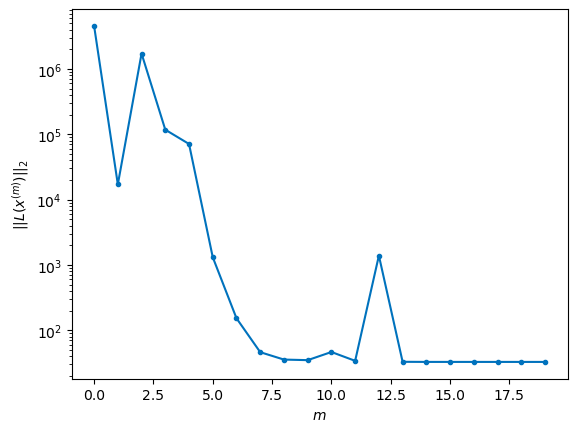

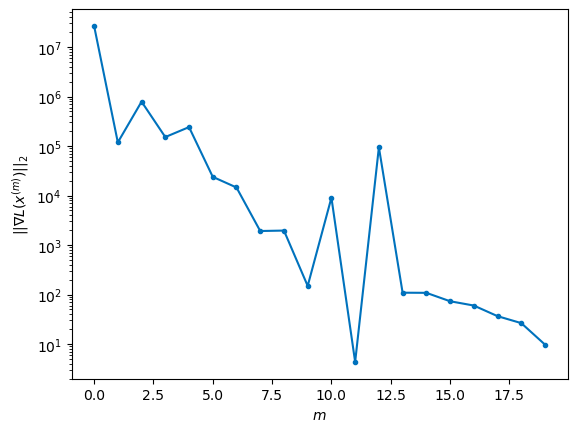

2412561.36501046 2412777.770402842 2412142.748797922 2412318.8330152407
Before applying the algorithm
L_norm = 38.5497225258801
Grad_L_norm = 11762.081314728313

Iteration 1
L_norm = 33.25401900114461
Grad_L_norm = 505.50665371585177

Iteration 2
L_norm = 33.186710596909315
Grad_L_norm = 14.130769028631342

Iteration 3
L_norm = 33.18617427047862
Grad_L_norm = 172.37345554437633

STOP on Iteration 4
L_norm = 33.1816529432505
Grad_L_norm = 0.44662621863300056



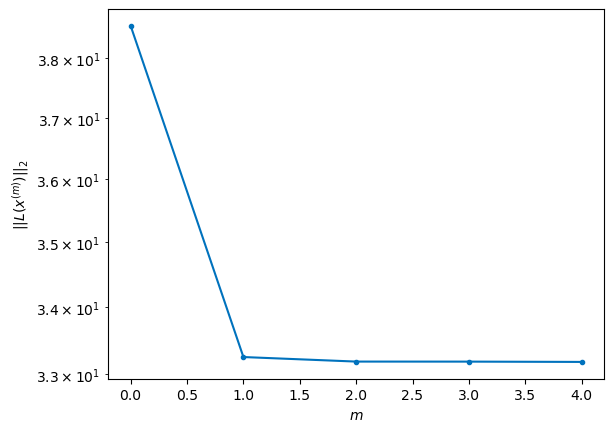

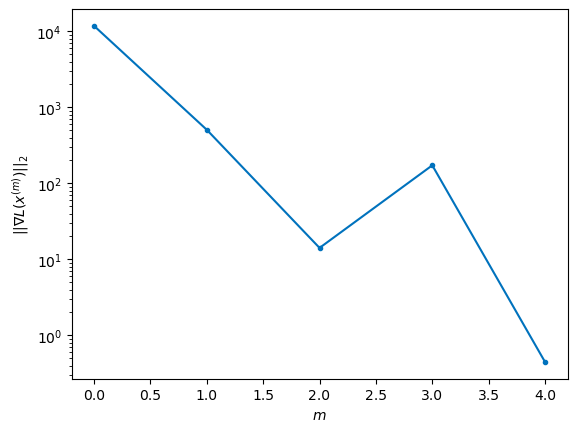

Before applying the algorithm
L_norm = 37.33006140751469
Grad_L_norm = 8782.703895954382

Iteration 1
L_norm = 34.33788917128774
Grad_L_norm = 112.92249461060845

Iteration 2
L_norm = 34.40756086717228
Grad_L_norm = 1040.9866119225971

Iteration 3
L_norm = 34.24495821074986
Grad_L_norm = 6.318850552182386

Iteration 4
L_norm = 34.294068693580066
Grad_L_norm = 694.2419608747675

STOP on Iteration 5
L_norm = 34.22350086672311
Grad_L_norm = 0.06301300266170563



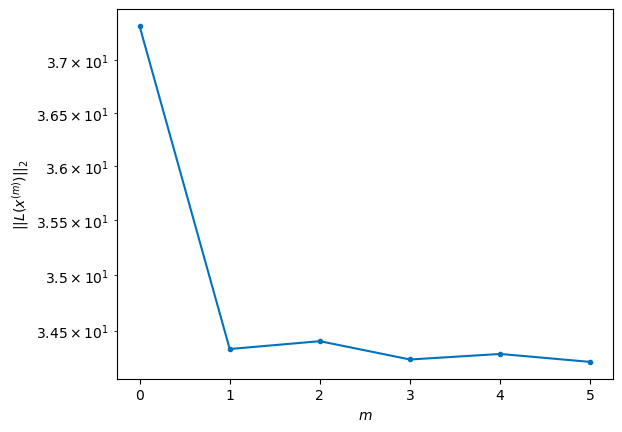

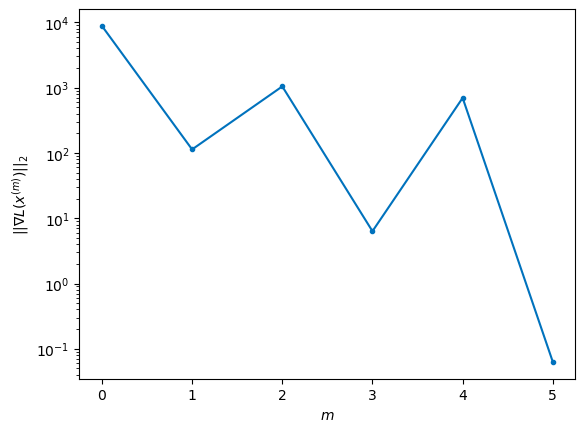

Before applying the algorithm
L_norm = 49.18298982555582
Grad_L_norm = 7970.6031785026

Iteration 1
L_norm = 37.843230884947324
Grad_L_norm = 685.247707782146

Iteration 2
L_norm = 37.21181387022481
Grad_L_norm = 329.30277098939894

Iteration 3
L_norm = 37.20691684877773
Grad_L_norm = 1551.5877520255237

Iteration 4
L_norm = 36.800465048290064
Grad_L_norm = 58.539194716362594

Iteration 5
L_norm = 40.22000466816102
Grad_L_norm = 5107.444147106799

Iteration 6
L_norm = 36.465846313503256
Grad_L_norm = 1.2324100489713603

Iteration 7
L_norm = 36.73016001215425
Grad_L_norm = 1470.059941037067

STOP on Iteration 8
L_norm = 36.41958808366605
Grad_L_norm = 0.030946882823770283



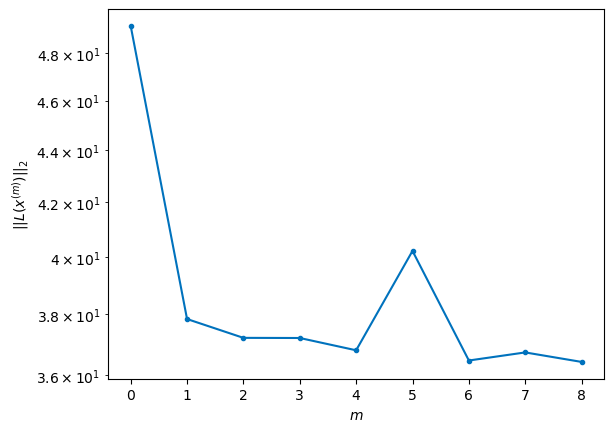

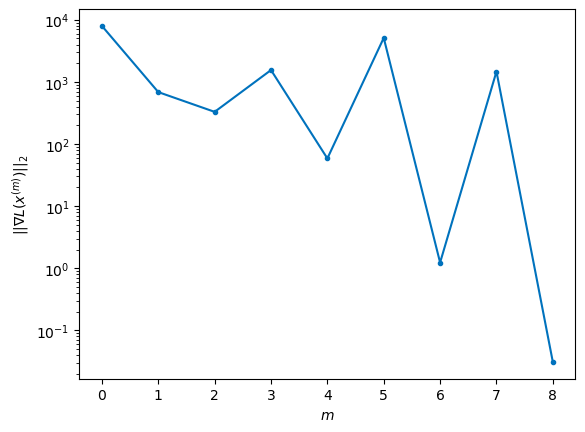

Before applying the algorithm
L_norm = 38.735125148767224
Grad_L_norm = 9942.776877642926

Iteration 1
L_norm = 34.58493755205929
Grad_L_norm = 214.54081036818678

Iteration 2
L_norm = 34.54975228315141
Grad_L_norm = 35.92678144928146

Iteration 3
L_norm = 34.54601166476936
Grad_L_norm = 86.15441882623338

Iteration 4
L_norm = 34.544751630891646
Grad_L_norm = 2.355379957758747

Iteration 5
L_norm = 34.544709259674114
Grad_L_norm = 1.1794598834923185

STOP on Iteration 6
L_norm = 34.544709039076764
Grad_L_norm = 0.0009470472110842931



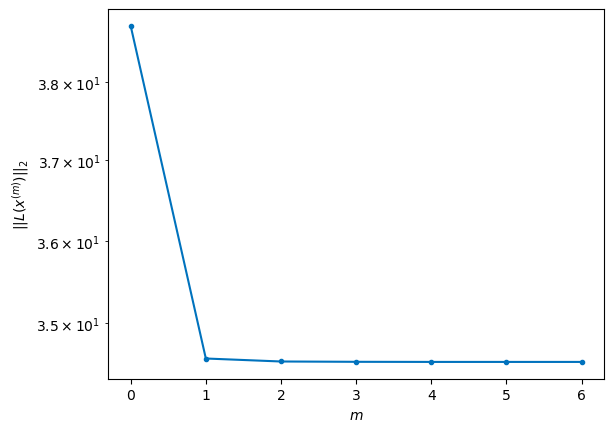

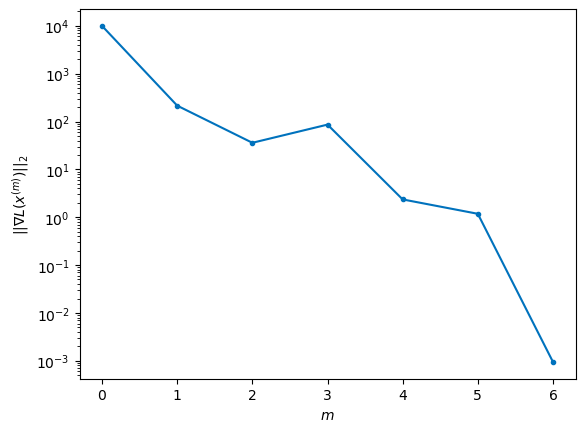

Before applying the algorithm
L_norm = 50.25164277527928
Grad_L_norm = 16680.416483139896

Iteration 1
L_norm = 38.11810610410303
Grad_L_norm = 1277.0301275737716

Iteration 2
L_norm = 37.2620281647222
Grad_L_norm = 228.11574123905555

Iteration 3
L_norm = 38.74665035114965
Grad_L_norm = 3853.640369374601

Iteration 4
L_norm = 36.508758899558714
Grad_L_norm = 13.332647021381147

Iteration 5
L_norm = 49.856386771472096
Grad_L_norm = 9867.081425532762

STOP on Iteration 6
L_norm = 36.064501549517345
Grad_L_norm = 0.9035568832677191



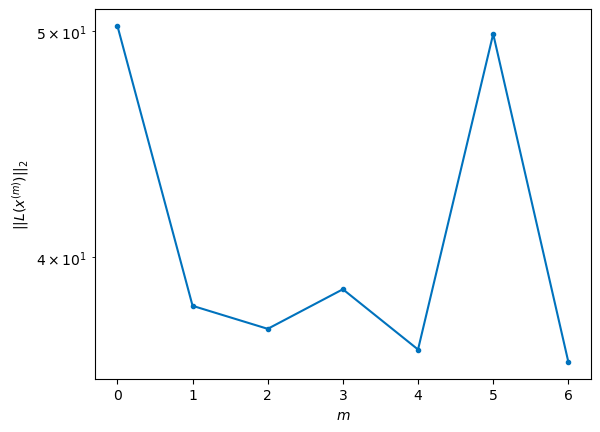

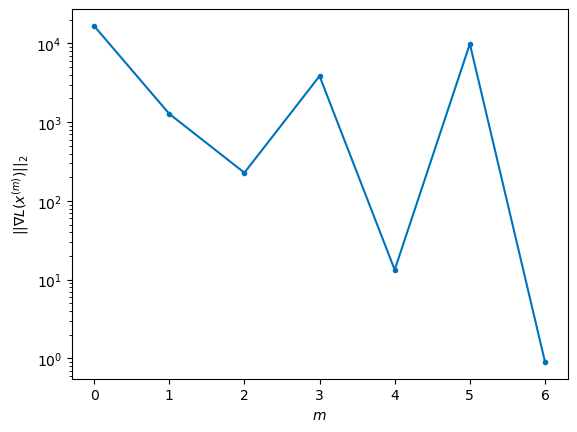

Before applying the algorithm
L_norm = 40.332775236305714
Grad_L_norm = 8414.360606678363

Iteration 1
L_norm = 35.63731833957894
Grad_L_norm = 651.0123047929237

Iteration 2
L_norm = 35.28542316267507
Grad_L_norm = 85.08671466379185

Iteration 3
L_norm = 35.39340229441884
Grad_L_norm = 1229.7195874431397

Iteration 4
L_norm = 35.16766650924342
Grad_L_norm = 4.585920436624478

Iteration 5
L_norm = 35.16795677938463
Grad_L_norm = 315.6710281578858

STOP on Iteration 6
L_norm = 35.15403207602898
Grad_L_norm = 0.025448795996032107



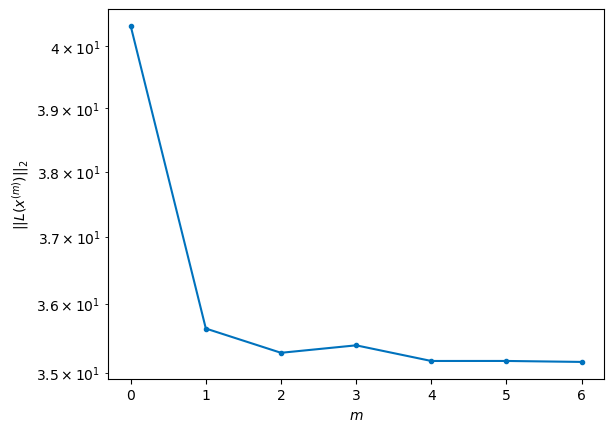

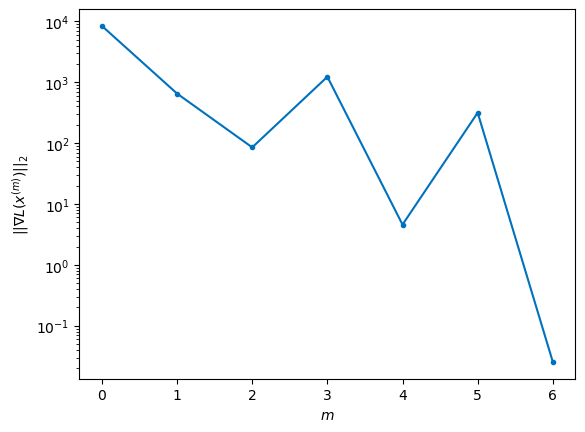

Before applying the algorithm
L_norm = 40.055748235220854
Grad_L_norm = 6590.056095879343

Iteration 1
L_norm = 34.84812556897126
Grad_L_norm = 185.00472472848946

Iteration 2
L_norm = 34.8068200232643
Grad_L_norm = 27.16373668265215

Iteration 3
L_norm = 34.80570905301296
Grad_L_norm = 4.437631290204289

STOP on Iteration 4
L_norm = 34.80569838508051
Grad_L_norm = 0.1224094061932252



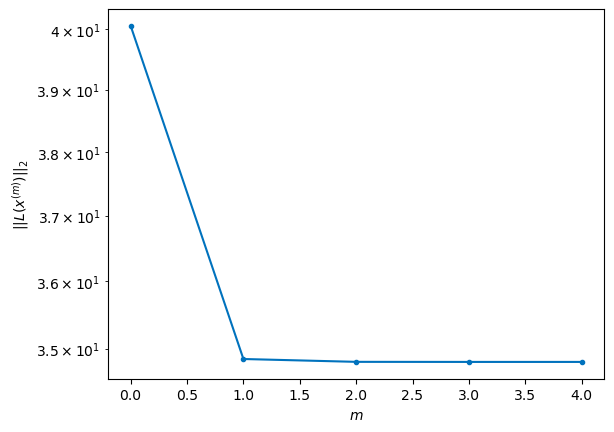

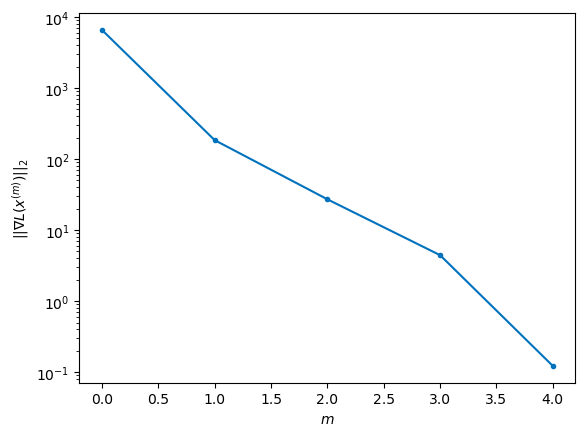

Before applying the algorithm
L_norm = 38.601242795836136
Grad_L_norm = 9715.239075494901

Iteration 1
L_norm = 33.11099207413855
Grad_L_norm = 429.7285495623627

Iteration 2
L_norm = 32.06007017771571
Grad_L_norm = 66.96533024129381

Iteration 3
L_norm = 34.03114576534331
Grad_L_norm = 3037.7704702285087

Iteration 4
L_norm = 31.032640102070374
Grad_L_norm = 5.706596251859598

Iteration 5
L_norm = 39.63441744364042
Grad_L_norm = 5686.5492623326345

STOP on Iteration 6
L_norm = 30.534807068275686
Grad_L_norm = 0.47043554194650944



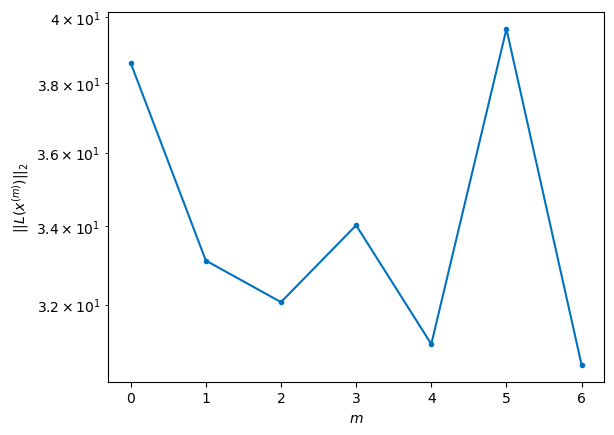

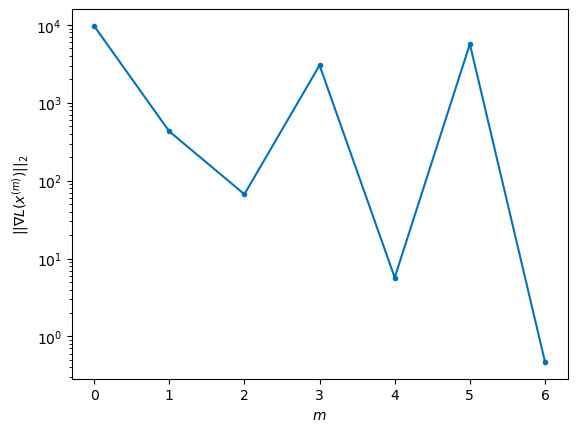

Before applying the algorithm
L_norm = 36.89033066018576
Grad_L_norm = 7872.678323185682

Iteration 1
L_norm = 4958.980933843081
Grad_L_norm = 69660.52928838647

Iteration 2
L_norm = 61.51237568447495
Grad_L_norm = 1060.8873197640944

Iteration 3
L_norm = 52.3438032410132
Grad_L_norm = 2474.8373143158374

Iteration 4
L_norm = 36.32677811824824
Grad_L_norm = 1542.5023360668513

Iteration 5
L_norm = 35.01252385722377
Grad_L_norm = 999.567638248775

Iteration 6
L_norm = 32.222488904211765
Grad_L_norm = 245.166919751837

Iteration 7
L_norm = 33.91256267000787
Grad_L_norm = 1427.4517601615498

Iteration 8
L_norm = 31.077746403824435
Grad_L_norm = 11.568005299489236

Iteration 9
L_norm = 37.26082643939071
Grad_L_norm = 3267.2508617432586

Iteration 10
L_norm = 30.634385052706353
Grad_L_norm = 2.288381331424542

Iteration 11
L_norm = 30.63089808249736
Grad_L_norm = 144.41662094552825

STOP on Iteration 12
L_norm = 30.624877509260447
Grad_L_norm = 0.005581532376927892



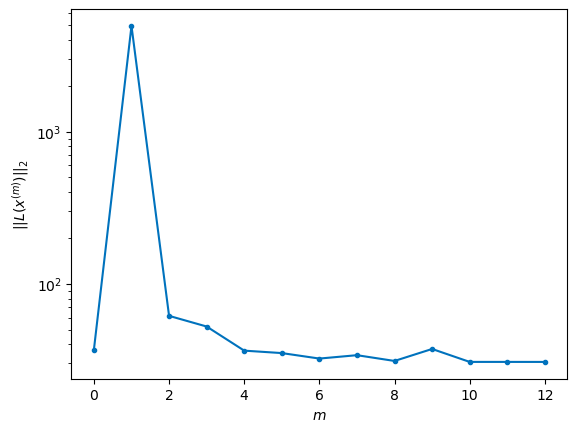

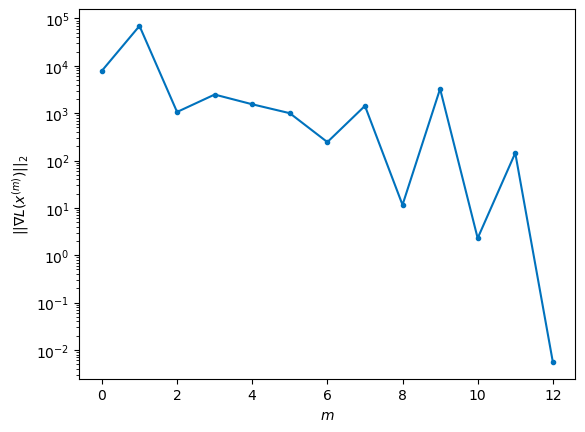

Before applying the algorithm
L_norm = 29.710548644257038
Grad_L_norm = 8029.827197341292

Iteration 1
L_norm = 26.619210516573393
Grad_L_norm = 1145.7534046371786

Iteration 2
L_norm = 26.053111877114624
Grad_L_norm = 84.52056085288935

Iteration 3
L_norm = 26.148229224317234
Grad_L_norm = 623.2589203520843

Iteration 4
L_norm = 25.8296681745482
Grad_L_norm = 9.58551781724246

Iteration 5
L_norm = 25.875204422201275
Grad_L_norm = 382.13090863204013

STOP on Iteration 6
L_norm = 25.802888416331257
Grad_L_norm = 0.7219695554506815



MC run: 100%|██████████| 1/1 [00:31<00:00, 31.36s/it]

This MC run RMSE for the first 386 iterations:
RMSE_run1_1 = 9684009.270738179
RMSE_run1_2 = 9685610.472751541
RMSE_run1_3 = 9680879.509381196
RMSE_run1_4 = 9685094.619169526

Average RMSE for the first 386 iterations for 1 (100.0 %) valid Monte Carlo runs:
RMSE_1 = 9684009.270738179
RMSE_2 = 9685610.472751541
RMSE_3 = 9680879.509381196
RMSE_4 = 9685094.619169526
The first round of NKKT converged with 19.0 iterations on average.
The next 385 rounds of NKKT converged with 6.333333333333333 iterations on average.
(3, 1, 386)


In [88]:
rmse_1 = []
rmse_2 = []
rmse_3 = []
rmse_4 = []
NKKT_first_round_stop_iteration = []
NKKT_K_minus_W_next_rounds_stop_iteration = []
for m in tqdm(range(M), desc="MC run", leave=True):
    print(f"------------------------------------ Monte Carlo run #{m + 1} ------------------------------------")
    Y = np.zeros((9, 1, T))
    for t in range(T):
        Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))

    # Before applying the Newton algorithm for the first time, initialize the initial conditions guess randomly (cold-start) 
    x_init = np.zeros((4 * n_x, 1))
    x_init[:4*n_x, :] = X_est[:, :, 0]
    
    # Apply the algorithm
    p_1_est = np.zeros((n_p, 1, K - W + 1))
    p_2_est = np.zeros((n_p, 1, K - W + 1))
    p_3_est = np.zeros((n_p, 1, K - W + 1))
    p_4_est = np.zeros((n_p, 1, K - W + 1))
    for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
        nkkt = NKKT()
        x_est = nkkt.solve(x_init, Y[:, :, n:n + W])
        p_1_est[:, :, n] = P @ x_est[:n_x, :]
        p_2_est[:, :, n] = P @ x_est[n_x:2*n_x, :]
        p_3_est[:, :, n] = P @ x_est[2*n_x:3*n_x, :]
        p_4_est[:, :, n] = P @ x_est[3*n_x:, :]

        
        if n == 10:
            for k in range(n, K - W + 1):
                x_1_k = x_est[:n_x, :]
                x_2_k = x_est[n_x:2*n_x, :]
                x_3_k = x_est[2*n_x:3*n_x, :]
                x_4_k = x_est[3*n_x:, :]
                p_1_est[:, :, k] = P @ x_1_k
                p_2_est[:, :, k] = P @ x_2_k
                p_3_est[:, :, k] = P @ x_3_k
                p_4_est[:, :, k] = P @ x_4_k
                x_1_k = SatelliteDynamics().x_new(dt, x_1_k)
                x_2_k = SatelliteDynamics().x_new(dt, x_2_k)
                x_3_k = SatelliteDynamics().x_new(dt, x_3_k)
                x_4_k = SatelliteDynamics().x_new(dt, x_4_k)
            dev_chief = np.linalg.norm(p_1_est - X_true[:3, :, :K - W + 1], axis=0).reshape(-1, 1)
            dev_deputy1 = np.linalg.norm(p_2_est - X_true[6:9, :, :K - W + 1], axis=0).reshape(-1, 1)
            dev_deputy2 = np.linalg.norm(p_3_est - X_true[12:15, :, :K - W + 1], axis=0).reshape(-1, 1)
            dev_deputy3 = np.linalg.norm(p_4_est - X_true[18:21, :, :K - W + 1], axis=0).reshape(-1, 1)
            break
        
        give_me_the_plots(nkkt.i, nkkt.L_norms, nkkt.grad_L_norms)

        if n == 0: # Check divergence in the beginning
            abs_error_init_1 = np.zeros(W)
            abs_error_init_2 = np.zeros(W)
            abs_error_init_3 = np.zeros(W)
            abs_error_init_4 = np.zeros(W)
            for k in range(W):
                x_1_k = x_est[:n_x, :]
                x_2_k = x_est[n_x:2*n_x, :]
                x_3_k = x_est[2*n_x:3*n_x, :]
                x_4_k = x_est[3*n_x:, :]
                abs_error_init_1[k] = np.linalg.norm(P @ x_1_k - P @ X_true[:n_x, :, k])
                abs_error_init_2[k] = np.linalg.norm(P @ x_2_k - P @ X_true[n_x:2*n_x, :, k])
                abs_error_init_3[k] = np.linalg.norm(P @ x_3_k - P @ X_true[2*n_x:3*n_x, :, k])
                abs_error_init_4[k] = np.linalg.norm(P @ x_4_k - P @ X_true[3*n_x:4*n_x, :, k])
                x_1_k = SatelliteDynamics().x_new(dt, x_1_k)
                x_2_k = SatelliteDynamics().x_new(dt, x_2_k)
                x_3_k = SatelliteDynamics().x_new(dt, x_3_k)
                x_4_k = SatelliteDynamics().x_new(dt, x_4_k)
            rmse_init_1 = np.sqrt(np.mean(abs_error_init_1 ** 2))
            rmse_init_2 = np.sqrt(np.mean(abs_error_init_2 ** 2))
            rmse_init_3 = np.sqrt(np.mean(abs_error_init_3 ** 2))
            rmse_init_4 = np.sqrt(np.mean(abs_error_init_4 ** 2))
            print(rmse_init_1, rmse_init_2, rmse_init_3, rmse_init_4)
            if rmse_init_1 > 1e20 or rmse_init_2 > 1e20 or rmse_init_3 > 1e20 or rmse_init_4 > 1e20:
                print(f"This Monte Carlo run #{m + 1} diverged!")
                # Mimic the propagation for rmse computation below
                for k in range(K - W + 1):
                    x_1_k = x_est[:n_x, :]
                    x_2_k = x_est[n_x:2*n_x, :]
                    x_3_k = x_est[2*n_x:3*n_x, :]
                    x_4_k = x_est[3*n_x:, :]
                    p_1_est[:, :, k] = P @ x_1_k
                    p_2_est[:, :, k] = P @ x_2_k
                    p_3_est[:, :, k] = P @ x_3_k
                    p_4_est[:, :, k] = P @ x_4_k
                    x_1_k = SatelliteDynamics().x_new(dt, x_1_k)
                    x_2_k = SatelliteDynamics().x_new(dt, x_2_k)
                    x_3_k = SatelliteDynamics().x_new(dt, x_3_k)
                    x_4_k = SatelliteDynamics().x_new(dt, x_4_k)
                break
            else:
                NKKT_first_round_stop_iteration.append(nkkt.i)
        else:
            NKKT_K_minus_W_next_rounds_stop_iteration.append(nkkt.i)

        # Get next new guess (warm-start)
        # The initial guess is the previous window estimate second timestamp value
        x_init[:n_x, :] = SatelliteDynamics().x_new(dt, x_est[:n_x, :])
        x_init[n_x:2*n_x, :] = SatelliteDynamics().x_new(dt, x_est[n_x:2*n_x, :])
        x_init[2*n_x:3*n_x, :] = SatelliteDynamics().x_new(dt, x_est[2*n_x:3*n_x, :])
        x_init[3*n_x:4*n_x, :] = SatelliteDynamics().x_new(dt, x_est[3*n_x:, :])

    # After each Monte Carlo Run compute the RMSE_m for each first K - W + 1 iterations
    abs_error_1 = np.zeros(K - W + 1)
    abs_error_2 = np.zeros(K - W + 1)
    abs_error_3 = np.zeros(K - W + 1)
    abs_error_4 = np.zeros(K - W + 1)
    for k in range(K - W + 1):
        abs_error_1[k] = np.linalg.norm(p_1_est[:, :, k] - P @ X_true[:n_x, :, k])
        abs_error_2[k] = np.linalg.norm(p_2_est[:, :, k] - P @ X_true[n_x:2*n_x, :, k])
        abs_error_3[k] = np.linalg.norm(p_3_est[:, :, k] - P @ X_true[2*n_x:3*n_x, :, k])
        abs_error_4[k] = np.linalg.norm(p_4_est[:, :, k] - P @ X_true[3*n_x:4*n_x, :, k])
    rmse_m_1 = np.sqrt(np.mean(abs_error_1 ** 2))
    rmse_m_2 = np.sqrt(np.mean(abs_error_2 ** 2))
    rmse_m_3 = np.sqrt(np.mean(abs_error_3 ** 2))
    rmse_m_4 = np.sqrt(np.mean(abs_error_4 ** 2))
    print(f'This MC run RMSE for the first {K - W + 1} iterations:')
    print(f'RMSE_run{m + 1}_1 = {rmse_m_1}')
    print(f'RMSE_run{m + 1}_2 = {rmse_m_2}')
    print(f'RMSE_run{m + 1}_3 = {rmse_m_3}')
    print(f'RMSE_run{m + 1}_4 = {rmse_m_4}\n')
    if rmse_m_1 > 1e20 or rmse_m_2 > 1e20 or rmse_m_3 > 1e20 or rmse_m_4 > 1e20:
        print(f"Discarding this Monte Carlo run #{m + 1} and going to Monte Carlo run #{m + 2}...\n")
    else:
        rmse_1.append(rmse_m_1)
        rmse_2.append(rmse_m_2)
        rmse_3.append(rmse_m_3)
        rmse_4.append(rmse_m_4)
        
print(f'Average RMSE for the first {K - W + 1} iterations for {len(rmse_1)} ({len(rmse_1) / M * 100} %) valid Monte Carlo runs:')
print(f'RMSE_1 = {np.mean(rmse_1)}')
print(f'RMSE_2 = {np.mean(rmse_2)}')
print(f'RMSE_3 = {np.mean(rmse_3)}')
print(f'RMSE_4 = {np.mean(rmse_4)}')
print(f'The first round of NKKT converged with {np.mean(NKKT_first_round_stop_iteration)} iterations on average.')
print(f'The next {K - W} rounds of NKKT converged with {np.mean(NKKT_K_minus_W_next_rounds_stop_iteration)} iterations on average.')
print(np.shape(p_1_est))

In [ ]:
dev_chief = np.linalg.norm(p_1_est - X_true[:3, :, :K - W + 1], axis=0).reshape(-1, 1)
dev_deputy1 = np.linalg.norm(p_2_est - X_true[6:9, :, :K - W + 1], axis=0).reshape(-1, 1)
dev_deputy2 = np.linalg.norm(p_3_est - X_true[12:15, :, :K - W + 1], axis=0).reshape(-1, 1)
dev_deputy3 = np.linalg.norm(p_4_est - X_true[18:21, :, :K - W + 1], axis=0).reshape(-1, 1)

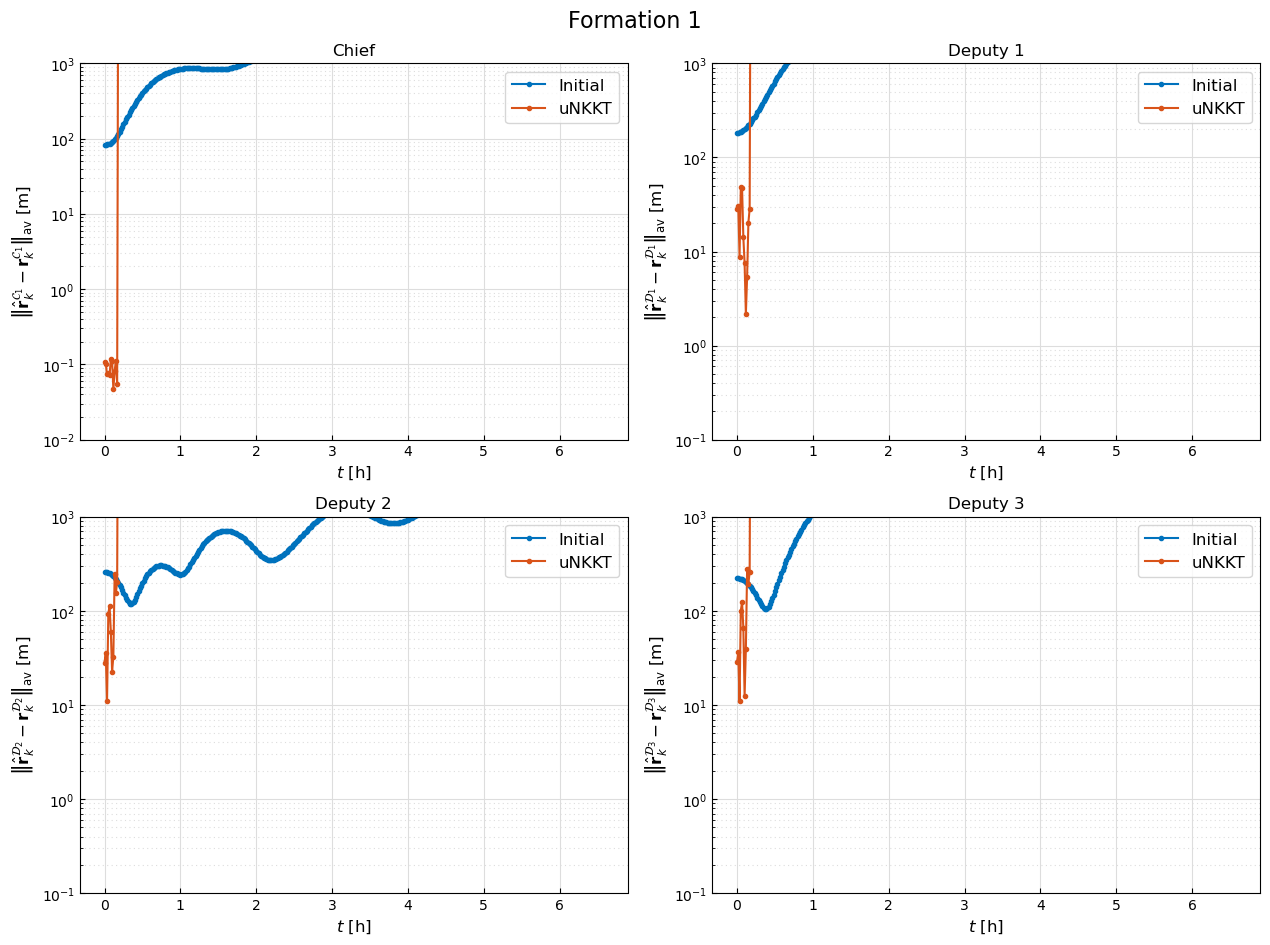

In [89]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt
algorithm = "uNKKT"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time[:K - W + 1], dev_chief, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time[:K - W + 1], dev_deputy1, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time[:K - W + 1], dev_deputy2, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time[:K - W + 1], dev_deputy3, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()